In [3]:
#Script to obtain data 
from helpers import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
df = pd.read_csv("data/data_moods.csv")

In [5]:
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [6]:
#Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [7]:
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [8]:
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)

In [9]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

C:\Users\dishita\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\dishita\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\dishita\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future ver

Baseline: 76.95% (4.06%)


C:\Users\dishita\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [10]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

C:\Users\dishita\AppData\Roaming\Python\Python39\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


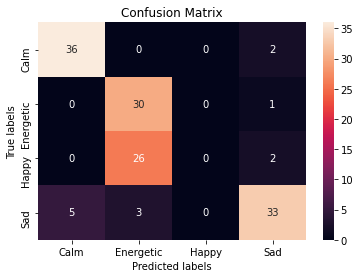

Accuracy Score 0.717391304347826


In [11]:

cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [13]:
def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
                                                                             batch_size=200,verbose=0))])
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]
    print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
    if mood[0].upper()=='HAPPY' or mood[0].upper()=='ENERGETIC':
        id='4VQMOVhJP7xEKM1y5H4YQM'
        endpoint_p="https://open.spotify.com/embed/playlist/"
        lookup_playlist=f"{endpoint_p}{id}"
        print("\nRecommended playlist of ENERGETIC songs is : ")
        print(lookup_playlist)
    else:
        id='0P5kYTgLdhrMq8UsEg4aYL'
        endpoint_p="https://open.spotify.com/embed/playlist/"
        lookup_playlist=f"{endpoint_p}{id}"
        print("\nRecommended playlist of RELAXING songs is : ")
        print(lookup_playlist)


    return 
    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")
    

In [27]:
id = get_song_id("Someone you loved")
final_id = id['tracks']['items'][0]['album']['artists'][0]['id']
print(final_id)

print(id)

4GNC7GD6oZMSxPGyXy4MNB
{'tracks': {'href': 'https://api.spotify.com/v1/search?query=Someone+you+loved&type=track&offset=0&limit=1', 'items': [{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4GNC7GD6oZMSxPGyXy4MNB'}, 'href': 'https://api.spotify.com/v1/artists/4GNC7GD6oZMSxPGyXy4MNB', 'id': '4GNC7GD6oZMSxPGyXy4MNB', 'name': 'Lewis Capaldi', 'type': 'artist', 'uri': 'spotify:artist:4GNC7GD6oZMSxPGyXy4MNB'}], 'available_markets': ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BN', 'BO', 'BR', 'BS', 'BT', 'BW', 'BY', 'BZ', 'CA', 'CD', 'CG', 'CH', 'CI', 'CL', 'CM', 'CO', 'CR', 'CV', 'CW', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DM', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FJ', 'FM', 'FR', 'GA', 'GB', 'GD', 'GE', 'GH', 'GM', 'GN', 'GQ', 'GR', 'GT', 'GW', 'GY', 'HK', 'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IS', 'IT', 'JM', 'JO', 'JP', 'KE', 'KG', 'KH', 'KI

In [25]:
#predict_mood('1UeeRb6xDhUFtdjEO48AZ5')
predict_mood(final_id)
https://open.spotify.com/track/7qEHsqek33rTcFNT9PFqLf?si=637e47546aba4a3f

KeyboardInterrupt: 